In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2 
import shap, datetime, warnings
warnings.filterwarnings('ignore')

c:\Users\Steven\Desktop\school github repos\svo-directed-practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [3]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [4]:
# Define the different sets of features to try
feature_sets = {
    'all': sentiment_cols + finance_vars + time_cols 
}

In [5]:
y_cols = ['Volume']
y = df[y_cols]

In [6]:
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [7]:
predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [9]:
# Add the tuned and retrained models as well
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_all_tuned_retrained.pkl', 'rb'))

x_cols = feature_sets['all']
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)
x_eval

array([[0.01515152, 0.02870813, 0.08074534, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01515152, 0.01913876, 0.1242236 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00956938, 0.01552795, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.00310559, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.03827751, 0.06521739, ..., 0.        , 0.        ,
        1.        ]])

In [13]:
x_eval.shape

(67558, 1576)

In [15]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=1000, replace=False), :]

In [16]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)

100%|===================| 999/1000 [14:14<00:00]        

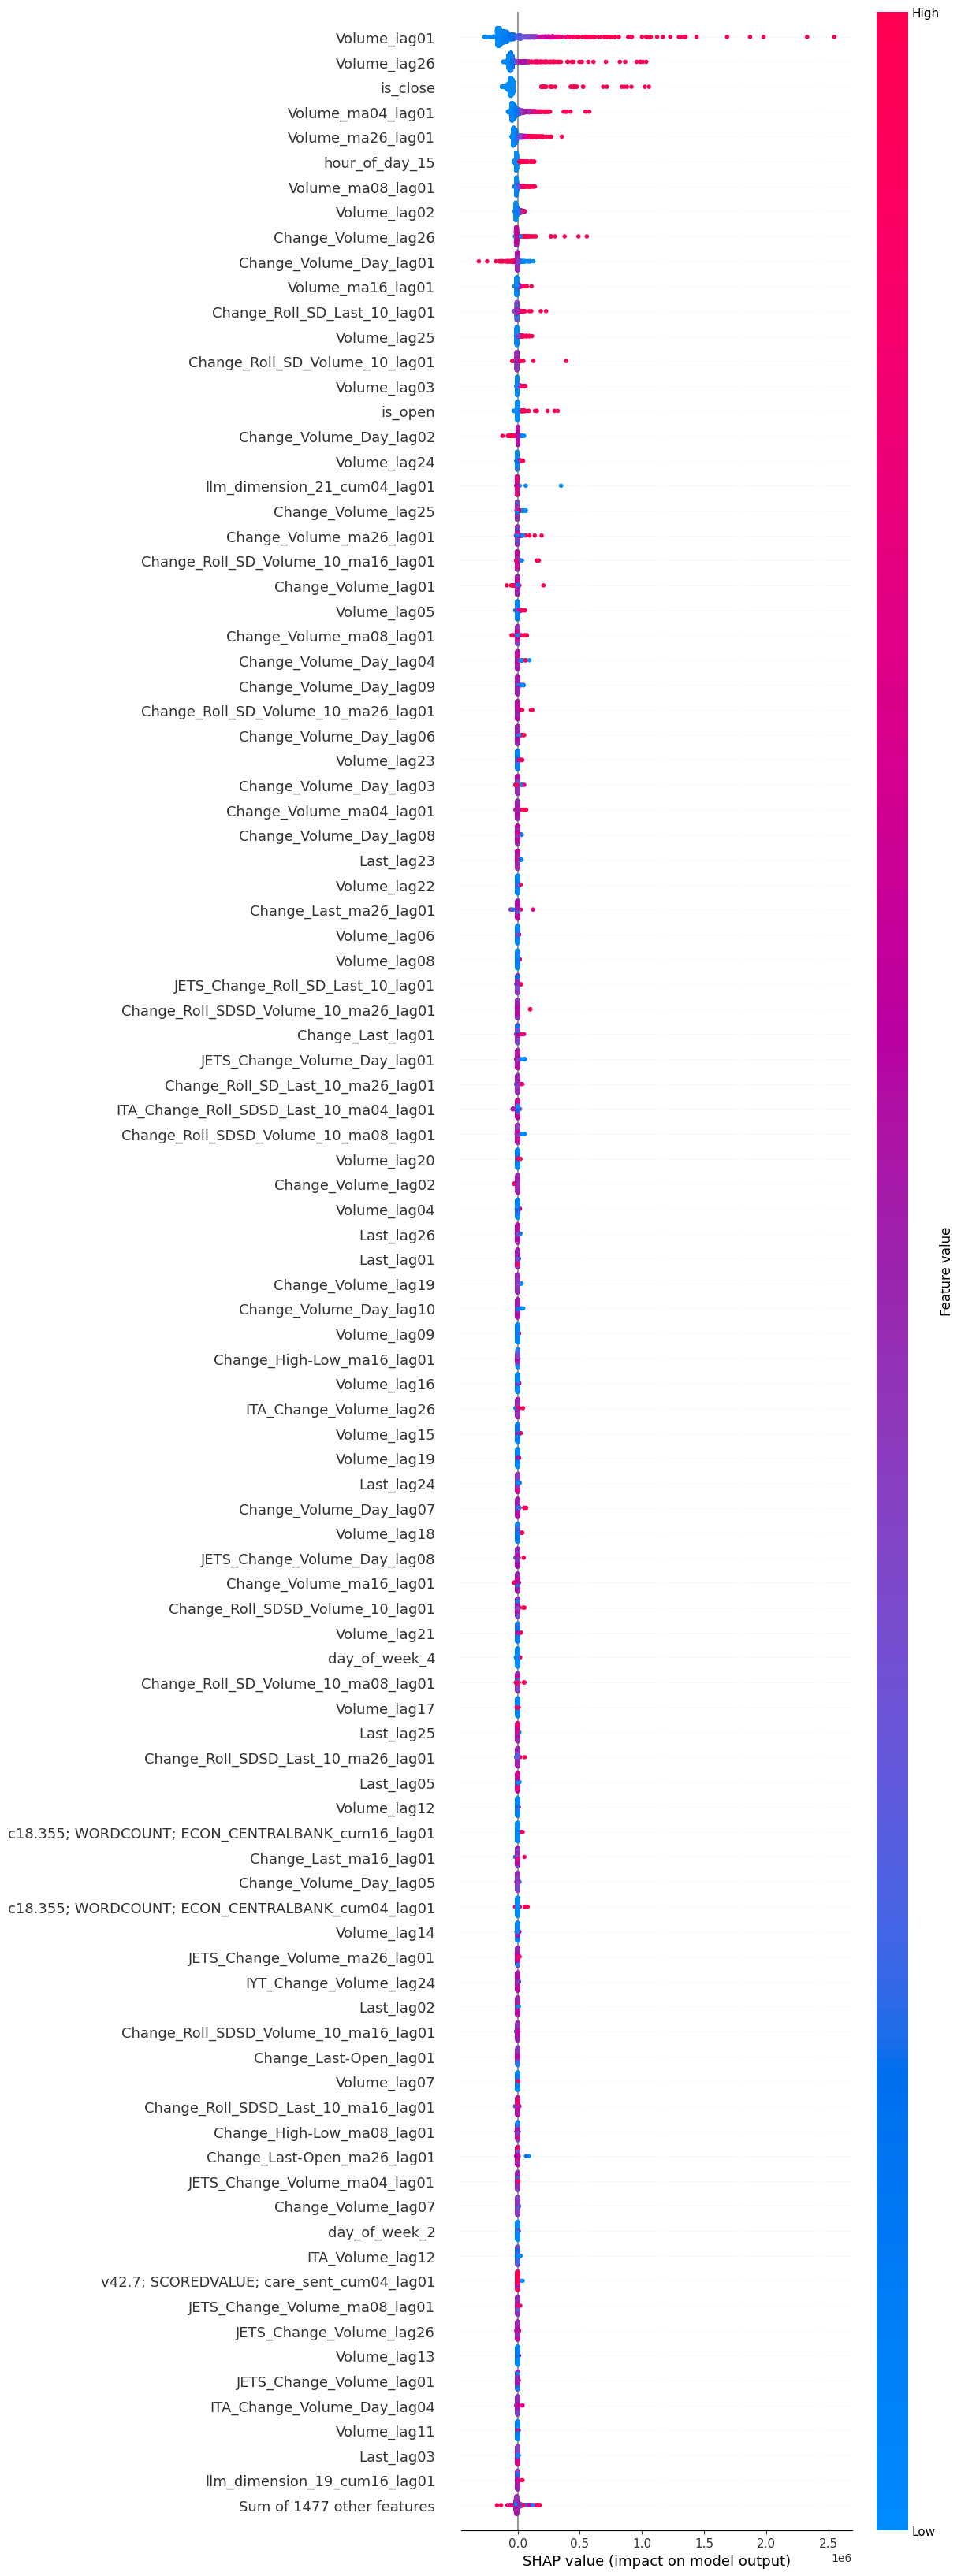

In [18]:
shap.plots.beeswarm(shap_values, max_display=100)